In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from safetensors.torch import save_model, load_model
from PIL import Image


In [2]:
#!kaggle datasets download --unzip --path data/lego-brick-images joosthazelzet/lego-brick-images

In [3]:
batch_size = 64
figsize = 16

In [4]:
!ls /home/jovyan/work/notebooks/data/lego-brick-images/

'Collada models'  'LEGO brick images v1'   dataset   validation.txt


In [5]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the images to 128x128
    transforms.ToTensor(),  # Convert the images to tensor
    transforms.Normalize((0.5,), (0.5,)),
])

class LegoDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        self.images = []
        for img_file in self.image_files:
            img_path = os.path.join(self.image_dir, img_file)
            image = Image.open(img_path).convert("L")
            if self.transform:
                image = self.transform(image)
            self.images.append(image)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        return self.images[idx]


In [6]:
lego_dataset = LegoDataset("/home/jovyan/work/notebooks/data/lego-brick-images/dataset", transform)
lego_loader = DataLoader(lego_dataset, batch_size, shuffle=True, drop_last=True)

In [7]:
def imshow(img):
    plt.figure(figsize=(figsize,figsize))
    plt.imshow(img.cpu().permute(1, 2, 0).numpy())
    plt.show()

In [8]:
# Get some random training images
images = next(iter(lego_loader))

In [9]:
images.max()

tensor(0.2706)

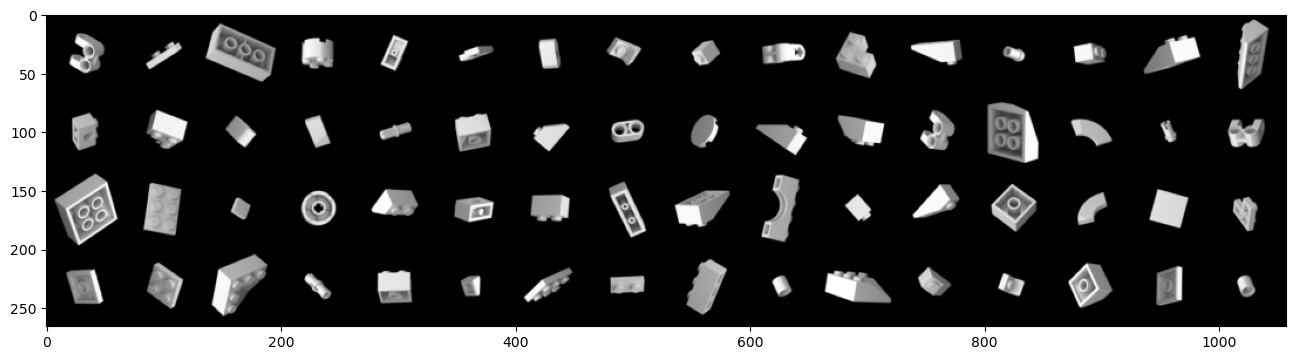

In [10]:
# Show images
imshow(torchvision.utils.make_grid(images, nrow=16, normalize=True))

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten(),
        )
    def forward(self, x):
        return self.main(x)

In [12]:
d_net = Discriminator().cuda()

In [13]:
summary(d_net, (batch_size, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [64, 1]                   --
├─Sequential: 1-1                        [64, 1]                   --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          1,024
│    └─LeakyReLU: 2-2                    [64, 64, 32, 32]          --
│    └─Dropout: 2-3                      [64, 64, 32, 32]          --
│    └─Conv2d: 2-4                       [64, 128, 16, 16]         131,072
│    └─BatchNorm2d: 2-5                  [64, 128, 16, 16]         256
│    └─LeakyReLU: 2-6                    [64, 128, 16, 16]         --
│    └─Dropout: 2-7                      [64, 128, 16, 16]         --
│    └─Conv2d: 2-8                       [64, 256, 8, 8]           524,288
│    └─BatchNorm2d: 2-9                  [64, 256, 8, 8]           512
│    └─LeakyReLU: 2-10                   [64, 256, 8, 8]           --
│    └─Dropout: 2-11                     [64, 256, 8, 8]           --


In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Unflatten(1, (100, 1, 1)),
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.main(x)

In [15]:
g_net = Generator().cuda()

In [16]:
summary(g_net, (batch_size, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [64, 1, 64, 64]           --
├─Sequential: 1-1                        [64, 1, 64, 64]           --
│    └─Unflatten: 2-1                    [64, 100, 1, 1]           --
│    └─ConvTranspose2d: 2-2              [64, 512, 4, 4]           819,200
│    └─BatchNorm2d: 2-3                  [64, 512, 4, 4]           1,024
│    └─LeakyReLU: 2-4                    [64, 512, 4, 4]           --
│    └─ConvTranspose2d: 2-5              [64, 256, 8, 8]           2,097,152
│    └─BatchNorm2d: 2-6                  [64, 256, 8, 8]           512
│    └─LeakyReLU: 2-7                    [64, 256, 8, 8]           --
│    └─ConvTranspose2d: 2-8              [64, 128, 16, 16]         524,288
│    └─BatchNorm2d: 2-9                  [64, 128, 16, 16]         256
│    └─LeakyReLU: 2-10                   [64, 128, 16, 16]         --
│    └─ConvTranspose2d: 2-11             [64, 64, 32, 32]      

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [18]:
g_net.apply(weights_init)
d_net.apply(weights_init)

loss_fn = nn.BCEWithLogitsLoss()
d_optimizer = optim.Adam(d_net.parameters(), 0.00001, (0.5, 0.999))
g_optimizer = optim.Adam(g_net.parameters(), 0.00004, (0.5, 0.999))
writer = SummaryWriter()

epochs = 100

idx = 0
for epoch in range(epochs):
    d_net.train()
    g_net.train()
    real_labels = torch.full((batch_size, 1), 1.0).cuda()
    fake_labels = torch.full((batch_size, 1), 0.0).cuda()
    for i, data in enumerate(lego_loader):
        idx+=1
        d_net.zero_grad()
        real_images = data.cuda()
        output = d_net(real_images)
        d_loss_real = loss_fn(output, real_labels)
        d_loss_real.backward()
        x_mean = output.mean().item()

        noise = torch.randn(batch_size, 100).cuda()
        fake_images = g_net(noise)
        output = d_net(fake_images.detach())
        d_loss_fake = loss_fn(output, fake_labels)
        d_loss_fake.backward()
        z1_mean = output.mean().item()
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.step()

        g_net.zero_grad()
        output = d_net(fake_images)
        g_loss = loss_fn(output, real_labels)
        g_loss.backward()
        z2_mean = output.mean().item()
        g_optimizer.step()
        
        writer.add_scalar('d_loss', d_loss.item(), idx)
        writer.add_scalar('g_loss', g_loss.item(), idx)
        writer.add_scalar('x_mean', x_mean, idx) 
        writer.add_scalar('z1_mean', z1_mean, idx) 
        writer.add_scalar('z2_mean', z2_mean, idx) 

    d_net.eval()
    g_net.eval()
    with torch.no_grad():
        sample_noise = torch.randn(batch_size, 100).cuda()
        sample_images = g_net(sample_noise)
        grid = torchvision.utils.make_grid(sample_images, nrow=16, normalize=True)
        writer.add_image('Generated Images', grid, epoch)



In [19]:
save_model(d_net, "data/dc_gan.d_net.safetensors")
save_model(g_net, "data/dc_gan.g_net.safetensors")

In [20]:
load_model(d_net, "data/dc_gan.d_net.safetensors")
load_model(g_net, "data/dc_gan.g_net.safetensors")

(set(), [])

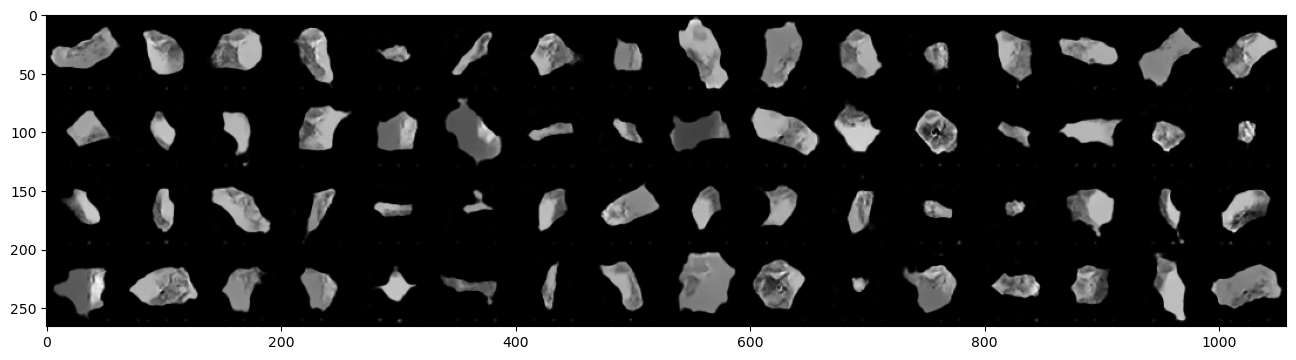

In [21]:
d_net.eval()
d_net.eval()
with torch.no_grad():
    sample_noise = torch.randn(batch_size, 100).cuda()
    sample_images = g_net(sample_noise)
    grid = torchvision.utils.make_grid(sample_images, nrow=16, normalize=True)
    imshow(grid)


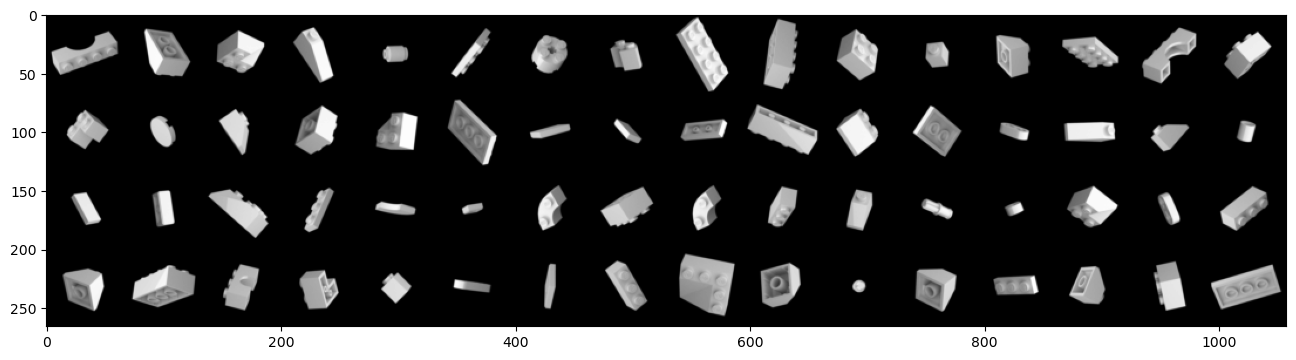

In [22]:
loader = DataLoader(lego_dataset, len(lego_dataset), shuffle=True, drop_last=True)
images = next(iter(loader))
images = images.cuda()
best_images = []
for i, sample_image in enumerate(sample_images):
    max_diff = 99999
    cur_image = None
    for image in images:
        diff = (image - sample_image).abs().mean()
        if diff < max_diff:
            max_diff = diff
            cur_image = image
    best_images.append(cur_image)
grid = torchvision.utils.make_grid(best_images, nrow=16, normalize=True)
imshow(grid)
